In [1]:
import pandas as pd
import numpy as np
import math
from pandas.tseries.holiday import USFederalHolidayCalendar
from datetime import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import median_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [2]:
df = pd.read_csv("dataclean/trip.csv")

# df.head()

In [3]:
df.duration /= 60
#df['duration'].quantile(0.995)
df = df[df.duration <= 720]
df.end_date = pd.to_datetime(df.end_date, format='%m/%d/%Y %H:%M')
# df.head()

In [4]:
df['date'] = df.end_date.dt.date

In [5]:
tripnum = {}
for d, index in zip(df.date,df.end_station_id):
    if index == 83:
        if d not in tripnum:
            tripnum[d] = 1
        else:
            tripnum[d] += 1
    else:
        if d not in tripnum:
            tripnum[d] = 0
# tripnum.keys()[dates.values().index(0)]


In [6]:
train = pd.DataFrame(tripnum.items(), columns=['date', 'trip_num']).sort('date')
train.reset_index(drop=True, inplace=True)
train.head()

/Users/fredlu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,date,trip_num
0,2013-08-29,0
1,2013-08-30,0
2,2013-08-31,0
3,2013-09-01,0
4,2013-09-02,0


In [7]:
weather = pd.read_csv("dataclean/weather.csv")
weather = weather[weather.zip_code == 94107]
weather.date = pd.to_datetime(weather.date, format='%m/%d/%Y')

In [8]:
# weather.events.unique()

In [9]:
weather.loc[weather.events.isnull(), 'events'] = 0
weather.loc[weather.events == 'rain', 'events'] = 1
weather.loc[weather.events == 'Fog-Rain', 'events'] = 3
weather.loc[weather.events == 'Fog', 'events'] = 2
weather.loc[weather.events == 'Rain-Thunderstorm', 'events'] = 5
weather.loc[weather.events == 'Rain', 'events'] = 4
# events = pd.get_dummies(weather.events)
# events
weather

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,2013-08-29,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,0,286.0,94107
1,2013-08-30,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,0,291.0,94107
2,2013-08-31,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,0,284.0,94107
3,2013-09-01,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,0,284.0,94107
4,2013-09-02,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,0,277.0,94107
5,2013-09-03,73.0,67.0,60.0,59.0,56.0,51.0,84.0,65.0,46.0,...,10.0,10.0,24.0,15.0,31.0,0,2.0,0,276.0,94107
6,2013-09-04,74.0,68.0,61.0,59.0,57.0,56.0,90.0,72.0,53.0,...,10.0,10.0,29.0,19.0,35.0,0,4.0,0,269.0,94107
7,2013-09-05,72.0,66.0,60.0,57.0,56.0,54.0,90.0,74.0,57.0,...,10.0,10.0,31.0,21.0,37.0,0,3.0,0,270.0,94107
8,2013-09-06,85.0,71.0,56.0,57.0,51.0,45.0,86.0,58.0,29.0,...,10.0,10.0,24.0,8.0,28.0,0,0.0,0,287.0,94107
9,2013-09-07,88.0,73.0,58.0,64.0,54.0,46.0,86.0,59.0,31.0,...,10.0,10.0,21.0,8.0,25.0,0,1.0,0,305.0,94107


In [10]:
weather = weather.drop(['zip_code','max_gust_speed_mph','max_temperature_f','min_temperature_f','max_dew_point_f','min_dew_point_f','max_humidity','min_humidity','max_sea_level_pressure_inches','min_sea_level_pressure_inches','max_visibility_miles','min_visibility_miles','precipitation_inches'],1)
weather.isnull().sum()


date                              0
mean_temperature_f                0
mean_dew_point_f                  0
mean_humidity                     0
mean_sea_level_pressure_inches    0
mean_visibility_miles             0
max_wind_Speed_mph                0
mean_wind_speed_mph               0
cloud_cover                       0
events                            0
wind_dir_degrees                  0
dtype: int64

In [11]:
weather

,date,mean_temperature_f,mean_dew_point_f,mean_humidity,mean_sea_level_pressure_inches,mean_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,cloud_cover,events,wind_dir_degrees
0,2013-08-29,68.0,58.0,75.0,30.02,10.0,23.0,11.0,4.0,0,286.0
1,2013-08-30,69.0,58.0,70.0,30.00,10.0,29.0,13.0,2.0,0,291.0
2,2013-08-31,64.0,56.0,75.0,29.96,10.0,26.0,15.0,4.0,0,284.0
3,2013-09-01,66.0,56.0,68.0,29.93,10.0,25.0,13.0,4.0,0,284.0
4,2013-09-02,69.0,60.0,77.0,29.94,10.0,23.0,12.0,6.0,0,277.0
5,2013-09-03,67.0,56.0,65.0,29.98,10.0,24.0,15.0,2.0,0,276.0
6,2013-09-04,68.0,57.0,72.0,30.01,10.0,29.0,19.0,4.0,0,269.0
7,2013-09-05,66.0,56.0,74.0,30.00,10.0,31.0,21.0,3.0,0,270.0
8,2013-09-06,71.0,51.0,58.0,29.92,10.0,24.0,8.0,0.0,0,287.0
9,2013-09-07,73.0,54.0,59.0,29.85,10.0,21.0,8.0,1.0,0,305.0


In [12]:
# weather.precipitation_inches = pd.to_numeric(weather.precipitation_inches, errors = 'coerce')
# weather.loc[weather.precipitation_inches.isnull(), 
#             'precipitation_inches'] = weather[weather.precipitation_inches.notnull()].precipitation_inches.median()
train = train.merge(weather, on = train.date)
train['date'] = train['date_x']
train.drop(['date_y','date_x'],1, inplace= True)
train.head()

,trip_num,mean_temperature_f,mean_dew_point_f,mean_humidity,mean_sea_level_pressure_inches,mean_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,cloud_cover,events,wind_dir_degrees,date
0,0,68.0,58.0,75.0,30.02,10.0,23.0,11.0,4.0,0,286.0,2013-08-29
1,0,69.0,58.0,70.0,30.00,10.0,29.0,13.0,2.0,0,291.0,2013-08-30
2,0,64.0,56.0,75.0,29.96,10.0,26.0,15.0,4.0,0,284.0,2013-08-31
3,0,66.0,56.0,68.0,29.93,10.0,25.0,13.0,4.0,0,284.0,2013-09-01
4,0,69.0,60.0,77.0,29.94,10.0,23.0,12.0,6.0,0,277.0,2013-09-02


In [13]:
stations = pd.read_csv("dataclean/station.csv")
stations.installation_date = pd.to_datetime(stations.installation_date, format = "%m/%d/%Y").dt.date
docks_num = []
for day in train.date:
    docks_num.append(sum(stations[stations.installation_date <= day].dock_count))
train['docks_num'] = docks_num

In [14]:
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=train.date.min(), end=train.date.max())
holidays = pd.to_datetime(holidays, format='%Y/%m/%d').date
train['isHoliday'] = train.date.isin(holidays)
train.isHoliday = train.isHoliday.map(lambda x: 1 if x == True else 0)
train.head()

,trip_num,mean_temperature_f,mean_dew_point_f,mean_humidity,mean_sea_level_pressure_inches,mean_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,cloud_cover,events,wind_dir_degrees,date,docks_num,isHoliday
0,0,68.0,58.0,75.0,30.02,10.0,23.0,11.0,4.0,0,286.0,2013-08-29,1150,0
1,0,69.0,58.0,70.0,30.00,10.0,29.0,13.0,2.0,0,291.0,2013-08-30,1150,0
2,0,64.0,56.0,75.0,29.96,10.0,26.0,15.0,4.0,0,284.0,2013-08-31,1150,0
3,0,66.0,56.0,68.0,29.93,10.0,25.0,13.0,4.0,0,284.0,2013-09-01,1150,0
4,0,69.0,60.0,77.0,29.94,10.0,23.0,12.0,6.0,0,277.0,2013-09-02,1150,1


In [15]:
train['year'] = pd.to_datetime(train['date']).dt.year
train['month'] = pd.to_datetime(train['date']).dt.month
train['day_in_week'] = pd.to_datetime(train['date']).dt.weekday
labels = train.trip_num
train = train.drop(['trip_num', 'date'], 1)
train

,mean_temperature_f,mean_dew_point_f,mean_humidity,mean_sea_level_pressure_inches,mean_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,cloud_cover,events,wind_dir_degrees,docks_num,isHoliday,year,month,day_in_week
0,68.0,58.0,75.0,30.02,10.0,23.0,11.0,4.0,0,286.0,1150,0,2013,8,3
1,69.0,58.0,70.0,30.00,10.0,29.0,13.0,2.0,0,291.0,1150,0,2013,8,4
2,64.0,56.0,75.0,29.96,10.0,26.0,15.0,4.0,0,284.0,1150,0,2013,8,5
3,66.0,56.0,68.0,29.93,10.0,25.0,13.0,4.0,0,284.0,1150,0,2013,9,6
4,69.0,60.0,77.0,29.94,10.0,23.0,12.0,6.0,0,277.0,1150,1,2013,9,0
5,67.0,56.0,65.0,29.98,10.0,24.0,15.0,2.0,0,276.0,1150,0,2013,9,1
6,68.0,57.0,72.0,30.01,10.0,29.0,19.0,4.0,0,269.0,1150,0,2013,9,2
7,66.0,56.0,74.0,30.00,10.0,31.0,21.0,3.0,0,270.0,1150,0,2013,9,3
8,71.0,51.0,58.0,29.92,10.0,24.0,8.0,0.0,0,287.0,1150,0,2013,9,4
9,73.0,54.0,59.0,29.85,10.0,21.0,8.0,1.0,0,305.0,1150,0,2013,9,5


In [16]:
X_train, X_test, y_train, y_test = train_test_split(train, labels, test_size=0.3, random_state = 2)
def scoring(clf):
    scores = cross_val_score(clf, X_train, y_train, cv=20, n_jobs=1, scoring = 'neg_median_absolute_error') * -1
    print np.median(scores) 

In [17]:
rfr = RandomForestRegressor(n_estimators = 55,
                            min_samples_leaf = 3,
                            random_state = 2)
scoring(rfr)

0.361317609159


In [18]:
gbr = GradientBoostingRegressor(learning_rate = 0.12,
                                n_estimators = 150,
                                max_depth = 8,
                                min_samples_leaf = 1,
                                random_state = 2)
scoring(gbr)

0.326392912234


In [19]:
dtr = DecisionTreeRegressor(min_samples_leaf = 3,
                            max_depth = 8,
                            random_state = 2)
scoring(dtr)

0.269696969697


In [20]:
abr = AdaBoostRegressor(n_estimators = 100,
                        learning_rate = 0.1,
                        loss = 'linear',
                        random_state = 2)
scoring(abr)

0.379


In [21]:
kr = KernelRidge( kernel='rbf', gamma=None, degree=3, coef0=1, kernel_params=None)
scoring(kr)

0.0325654458796


In [22]:
svr = SVR(kernel='rbf', degree=3, gamma='auto', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
scoring(svr)

0.380083772848


In [23]:
gp = GaussianProcessRegressor(kernel=None, alpha=1e-10, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=0, normalize_y=False, copy_X_train=True, random_state=None)
scoring(gp)

5.89562825213e-11


In [24]:
knr = KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=1)
scoring(knr)

0.4


In [25]:
br = BaggingRegressor(base_estimator=None, n_estimators=100, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=1, random_state=None, verbose=0)
scoring(br)

0.36


In [26]:
etr = ExtraTreesRegressor(n_estimators=100, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=False, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False)
scoring(etr)

0.3575


In [27]:
br = br.fit(X_train, y_train)
etr = etr.fit(X_train, y_train)

br_preds = br.predict(X_test)
etr_preds = etr.predict(X_test)

final_preds = br_preds*0.5 + etr_preds*0.5
print "Daily error of trip count:", median_absolute_error(y_test, final_preds)

Daily error of trip count: 0.335


In [28]:
y_test.reset_index(drop = True, inplace = True)

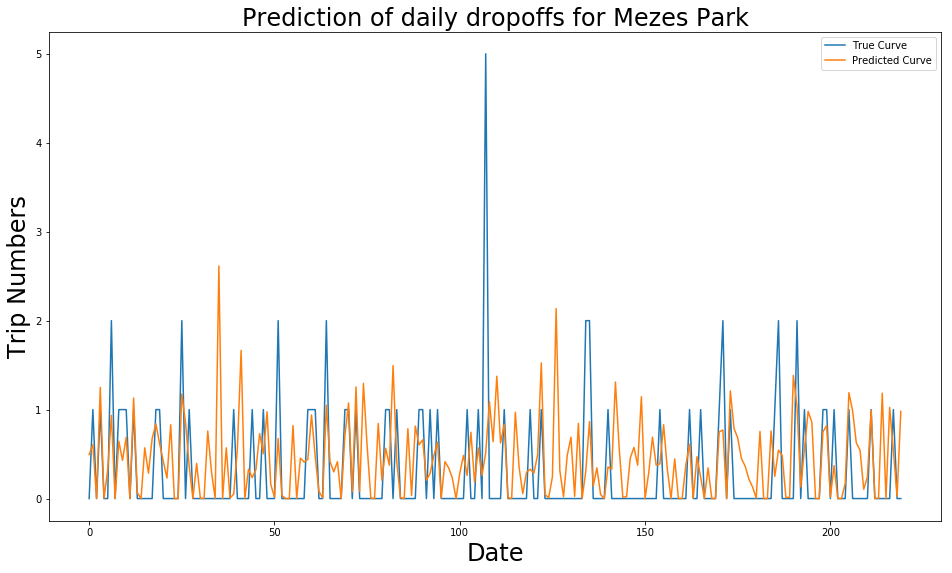

In [32]:
plt.figure(figsize=(16,9))
plt.plot(y_test)
plt.plot(final_preds)

plt.ylabel("Trip Numbers", fontsize = 24)
plt.xlabel("Date", fontsize = 24)
plt.legend(['True Curve','Predicted Curve'])
plt.title("Prediction of daily dropoffs for Mezes Park", fontsize = 24)
plt.show()

In [33]:
def feather_influence(model, model_name):
    importances = model.feature_importances_

    indices = np.argsort(importances)[::-1]    

    # Plot the feature importances of the forest
    plt.figure(figsize = (16,9))
    plt.title("Feature influence of " + model_name)
    plt.bar(range(X_train.shape[1]), importances[indices], color="b", align="center")
    plt.xticks(range(X_train.shape[1]), indices)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()

Feature ranking:
(0, 'mean_temperature_f')
(1, 'mean_dew_point_f')
(2, 'mean_humidity')
(3, 'mean_sea_level_pressure_inches')
(4, 'mean_visibility_miles')
(5, 'max_wind_Speed_mph')
(6, 'mean_wind_speed_mph')
(7, 'cloud_cover')
(8, 'events')
(9, 'wind_dir_degrees')
(10, 'docks_num')
(11, 'isHoliday')
(12, 'year')
(13, 'month')
(14, 'day_in_week')


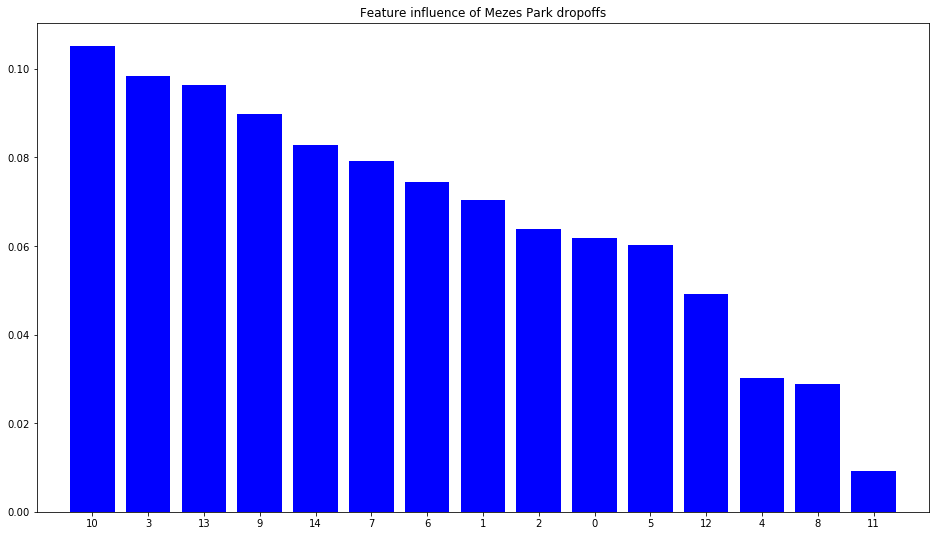

In [34]:
print("Feature ranking:")

i = 0
for feature in X_train:
    print (i, feature)
    i += 1
    
#feather_influence(br, "Bagging Regressor")
feather_influence(etr, "Mezes Park dropoffs")